# Convolution Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np
import os
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

2025-02-20 15:29:21.949307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.16.2'

In [3]:
# Variables
IMG_SIZE=128
BATCH_SIZE=40

## Part 1 - Data Preprocessing

In [4]:
import cv2
data_dir = 'chest_xray'

### Preprocessing the Data set

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])

train_data = tf.keras.utils.image_dataset_from_directory(
    'chest_xray/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size = BATCH_SIZE,
    label_mode = 'binary',
    shuffle=True
)

val_data = tf.keras.utils.image_dataset_from_directory(
    'chest_xray/val',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    color_mode='grayscale',
    label_mode = 'binary'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'chest_xray/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    color_mode='grayscale',
    label_mode = 'binary'
)

Found 5216 files belonging to 2 classes.
Found 17 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# Dealing with the imbalance

In [6]:
# Handle class imbalance using a simple ratio approach instead
total_samples = 0
positive_samples = 0

# Reset the dataset iterator
train_data_iter = iter(train_data)
try:
    while True:
        _, labels = next(train_data_iter)
        batch_labels = labels.numpy().ravel()
        total_samples += len(batch_labels)
        positive_samples += np.sum(batch_labels)
except StopIteration:
    pass

negative_samples = total_samples - positive_samples
pos_weight = negative_samples / positive_samples if positive_samples > 0 else 1.0
neg_weight = 1.0

# Create class weight dictionary
class_weight_dict = {0: neg_weight, 1: pos_weight}
print(f"Class weights - Normal (0): {neg_weight:.2f}, Pneumonia (1): {pos_weight:.2f}")

Class weights - Normal (0): 1.00, Pneumonia (1): 0.35


2025-02-20 15:29:37.489825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualising the Training Set

In [7]:
data_iterator = train_data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

In [9]:
batch[0].shape

(40, 128, 128, 1)

In [10]:
# class 1 = pneumonia
# class 0 = normal
batch[1]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

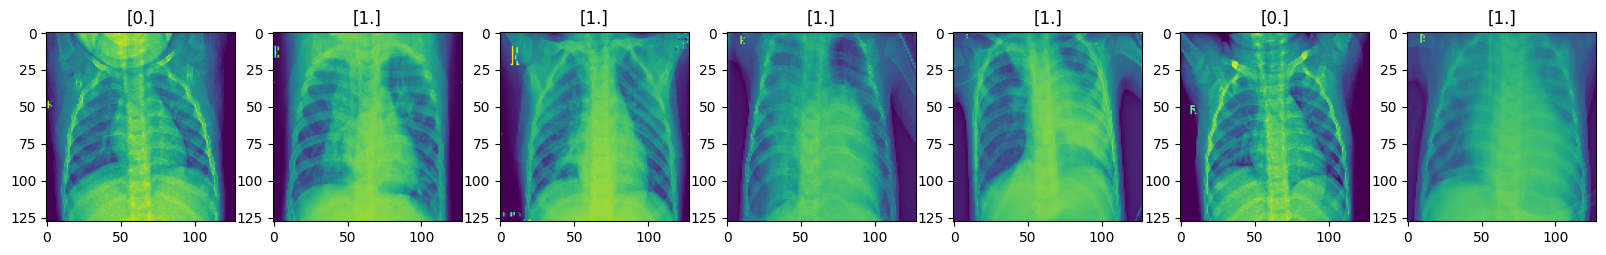

In [11]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
batch[0].min()

0.0

In [13]:
batch[0].max()

255.0

In [14]:
batch[0].shape

(40, 128, 128, 1)

In [15]:
scaled = batch[0]/255

In [16]:
scaled.max()

1.0

## Applying Lambda to the data sets for pipelining.

In [17]:
# Apply augmentation and normalization
augmented_data = train_data.map(lambda x, y: (data_augmentation(x), y))
val_data = val_data.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
test_data = test_data.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

# Visualizing the Augmented Training set

In [18]:
scaled_iterator = augmented_data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

In [20]:
batch [0].min()

0.0

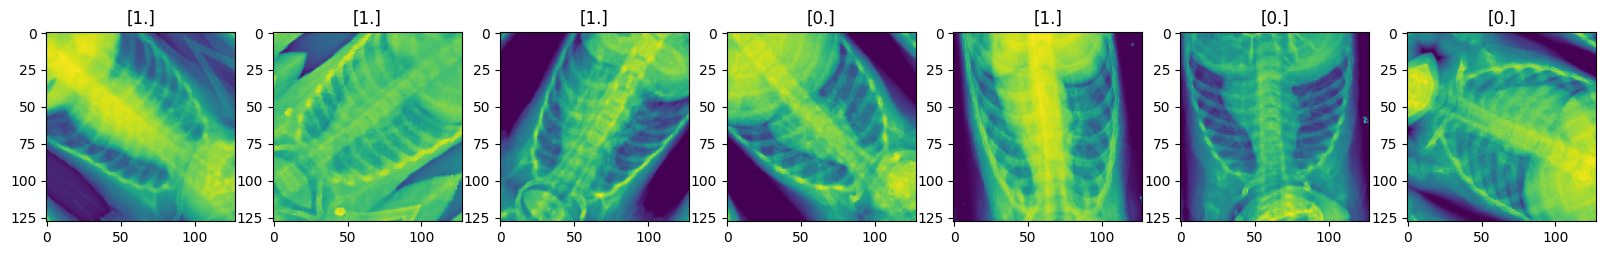

In [21]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Part 2 - Builind the CNN

### Initialising the CNN

### Step 1 -Convolution, Pooling, BatchNormalization, MaxPooling, Flattening, Dropout

In [22]:
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Part 3 - Training the CNN

### Compiling the CNN

In [23]:
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [24]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,200,609 (65.62 MB)

 Trainable params: 17,198,177 (65.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

### Training the CNN on the Training set and evaluating it on the Test Set

In [25]:
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Train the model
history = model.fit(
    augmented_data,
    validation_data=test_data,
    epochs=35,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.7899 - loss: 0.2458 - precision: 0.9499 - recall: 0.7568 - val_accuracy: 0.6250 - val_loss: 4.0678 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8894 - loss: 0.1463 - precision: 0.9672 - recall: 0.8819 - val_accuracy: 0.6250 - val_loss: 4.7179 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9105 - loss: 0.1237 - precision: 0.9760 - recall: 0.9030 - val_accuracy: 0.6250 - val_loss: 2.7963 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9208 - loss: 0.1040 - precision: 0.9766 - recall: 0.9159 - val_accuracy: 0.6410 - val_loss: 1.4855 - val_precision: 0.6352 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accur

In [26]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8984 - loss: 0.2503 - precision: 0.9120 - recall: 0.9279

Test Accuracy: 0.8958
Test Precision: 0.9114
Test Recall: 0.9231
Test F1 Score: 0.9172


In [27]:
# Save the model
model.save(os.path.join('model', 'improved_pneumonia_model4.keras'))

### Plot Performance

<function matplotlib.pyplot.show(close=None, block=None)>

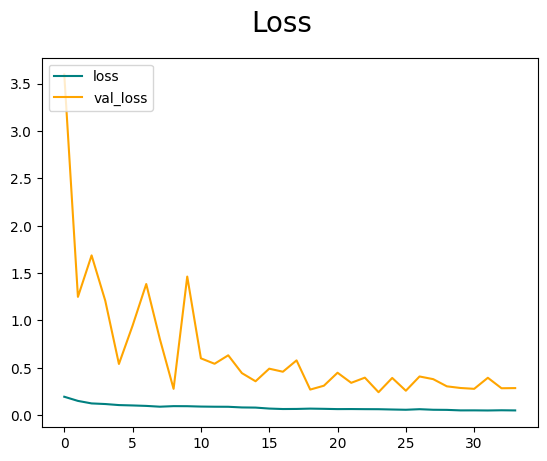

In [28]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

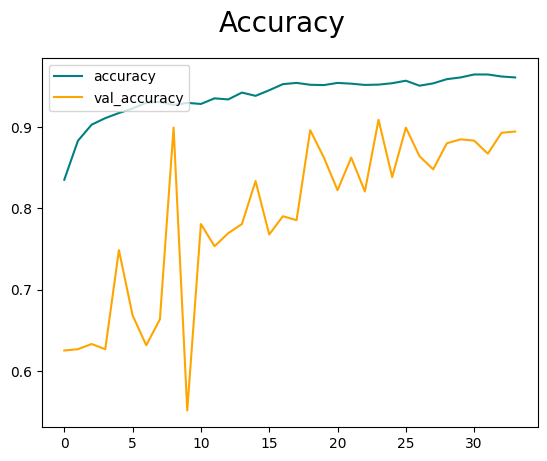

In [29]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show

# Part 4 -Making a single prediction

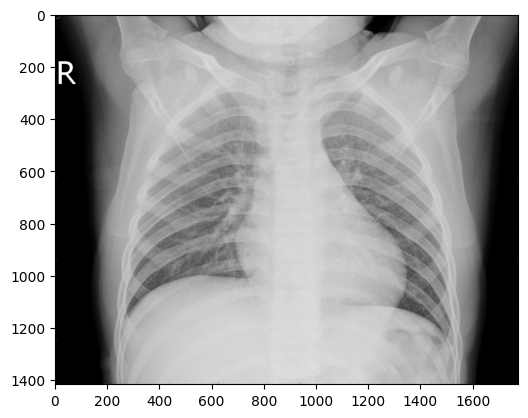

In [30]:
import cv2
img = cv2.imread('chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', 0)
plt.imshow(img, cmap='gray')
plt.show()

In [31]:
image = 'chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
#image = 'chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
# Prediction function
def predict_pneumonia(image):
    # Preprocess image
    image = np.expand_dims(image, axis=-1)
    resize = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    resize = resize / 255.0
    
    # Make prediction
    yhat = model.predict(np.expand_dims(resize, 0))
    pred_value = yhat[0][0]
    print(pred-value)
    
    return {
        'NORMAL': 1 - float(pred_value),
        'PNEUMONIA': float(pred_value)
    }

In [33]:
print(pred_value)

NameError: name 'pred_value' is not defined